# Efficient Portfolio Optimization

End-to-end Project

In [2]:
import pandas_datareader as wb
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib
import datetime as date
import numpy as np
import openpyxl as excel
np.random.seed(71)

import warnings
warnings.filterwarnings('ignore')

Preprocessing input data

In [4]:
usa, rus = [], []

with open('inputReal.csv', 'r') as f:
    for row in f:
        if 'США' in row:
            usa.append(row.split(',')[0])
        elif 'РОССИЯ' in row:
            rus.append(row.split(',')[0])

start = date.datetime(2019, 1, 1)
end = date.datetime(2019, 12, 31)

Uploading tickers' data

In [5]:
tickers = wb.DataReader(usa, 'yahoo', start, end)['Close']

for comp in rus:
    data = wb.DataReader(comp, 'moex', start, end)
    data = data[~data['BOARDID'].isin(('RPUA', 'RPEU', 'RPEO'))]['CLOSE'] / 64
    tickers = tickers.merge(data, how='inner', left_index=True, right_index=True)

tickers.columns = usa + rus

Calculating annual return.

In [7]:
returns = tickers.pct_change().mean(skipna=True) * 253
returns

NFLX     0.144446
WMT      0.265941
GOOGL    0.253705
GE       0.432897
GS       0.310999
F        0.178212
DIS      0.307947
MGNT     0.152056
AFLT     0.765851
LKOH     0.851725
dtype: float64

Calculating annual volatility.

In [8]:
covs = tickers.pct_change().cov() * 253
covs

,NFLX,WMT,GOOGL,GE,GS,F,DIS,MGNT,AFLT,LKOH
NFLX,0.116091,0.007107,0.033881,0.034819,0.021024,0.018343,0.006035,0.029035,0.020466,0.081742
WMT,0.007107,0.021317,0.008735,0.002211,0.010430,0.003489,0.008685,0.006800,-0.002305,0.006315
GOOGL,0.033881,0.008735,0.055084,0.022442,0.022156,0.014772,0.014972,0.001273,-0.014763,0.022776
GE,0.034819,0.002211,0.022442,0.166692,0.033606,0.040465,0.010644,0.037635,0.034669,0.073381
GS,0.021024,0.010430,0.022156,0.033606,0.055640,0.022414,0.012941,-0.008295,-0.026616,-0.007787
F,0.018343,0.003489,0.014772,0.040465,0.022414,0.075222,0.013426,0.005214,-0.000189,-0.015948
DIS,0.006035,0.008685,0.014972,0.010644,0.012941,0.013426,0.052064,0.003594,-0.038805,0.014506
MGNT,0.029035,0.006800,0.001273,0.037635,-0.008295,0.005214,0.003594,0.417802,0.088881,0.136137
AFLT,0.020466,-0.002305,-0.014763,0.034669,-0.026616,-0.000189,-0.038805,0.088881,1.512357,0.083693
LKOH,0.081742,0.006315,0.022776,0.073381,-0.007787,-0.015948,0.014506,0.136137,0.083693,1.386449


Initializing weights for Monte-carlo simulation.

In [9]:
weights = np.random.random(size=(100000, tickers.shape[1]))

Measuring Sharpe Ratio.

In [10]:
volatility = []
returns_weighted = []
covs = np.matrix(covs)

for weight in weights:
    return_per_weight = returns @ weight
    weight = weight.reshape((1,-1))
    vol = weight @ covs @ weight.T
    returns_weighted.append(return_per_weight)
    volatility.append(vol[0, 0])

risk_free = 0
sharpe = (np.array(returns_weighted) - risk_free) / np.sqrt(np.array(volatility))

Displaying the output for simulation.

In [11]:
ticker_columns = list(tickers.columns + ' wt')

df = pd.DataFrame(index=range(weights.shape[0]), columns=['Returns', 'Volatility', 'Sharpe Ratio'] + ticker_columns)

df[ticker_columns] = weights
df.Returns = returns_weighted
df.Volatility = np.sqrt(volatility)
df['Sharpe Ratio'] = sharpe

df

,Returns,Volatility,Sharpe Ratio,NFLX wt,WMT wt,GOOGL wt,GE wt,GS wt,F wt,DIS wt,MGNT wt,AFLT wt,LKOH wt
0,2.072649,1.472056,1.407996,0.185575,0.386599,0.831896,0.198697,0.916558,0.788311,0.722604,0.995695,0.845372,0.233727
1,1.919861,1.517517,1.265133,0.322414,0.716656,0.102832,0.600091,0.136264,0.899254,0.246007,0.953597,0.788291,0.434094
2,1.690661,1.110951,1.521814,0.254626,0.371629,0.569407,0.287561,0.859431,0.926623,0.0375025,0.324082,0.337842,0.627109
3,1.356515,0.818482,1.657354,0.075483,0.226522,0.920703,0.253677,0.876931,0.29083,0.236225,0.184916,0.137217,0.483095
4,2.255931,1.471381,1.533206,0.730692,0.768266,0.309795,0.694997,0.949949,0.529765,0.419374,0.564843,0.771723,0.43525
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.489262,0.917780,1.622679,0.934033,0.49244,0.553407,0.175288,0.90534,0.836383,0.289165,0.172191,0.385762,0.19469
99996,2.407907,1.746911,1.378380,0.210154,0.389001,0.814038,0.473677,0.530826,0.766069,0.557245,0.825639,0.977983,0.604396
99997,2.046950,1.345426,1.521414,0.482244,0.92637,0.596032,0.690149,0.607418,0.909888,0.215379,0.781995,0.625738,0.31165
99998,1.775058,1.264454,1.403814,0.664457,0.553467,0.0924125,0.251843,0.146591,0.690915,0.721397,0.487042,0.551352,0.601417


Discovering optimal portfolio.

In [12]:
max_sharpe = df.iloc[[df['Sharpe Ratio'].argmax()]]
max_sharpe

,Returns,Volatility,Sharpe Ratio,NFLX wt,WMT wt,GOOGL wt,GE wt,GS wt,F wt,DIS wt,MGNT wt,AFLT wt,LKOH wt
76061,0.972791,0.444442,2.188794,0.0549947,0.576891,0.377535,0.290225,0.554708,0.127764,0.817548,0.00463451,0.158775,0.0242592


Building an effective frontier.

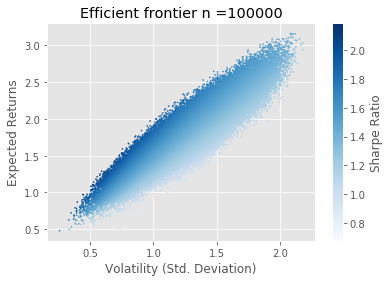

In [17]:
matplotlib.rc('font', size=8)
plot.style.use('ggplot')
plot.scatter(df.Volatility, df.Returns, s=1, c=df['Sharpe Ratio'], cmap='Blues')
plot.xlabel('Volatility (Std. Deviation)')
plot.ylabel('Expected Returns')
plot.colorbar(label='Sharpe Ratio')
plot.title('Efficient frontier n =' + str(weights.shape[0]))
plot.show()